# Analysis Summary

This notebook provides answers to questions about the open-coding analysis process itself.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from IPython.display import display, Markdown
from lib.util import getCodes

Import all codes from the open coding process

In [2]:
%%time
codes = getCodes()

CPU times: user 33.3 s, sys: 160 ms, total: 33.5 s
Wall time: 34.6 s


Parse works cited section of the `README.md` document for more analysis information.

In [3]:
# See regular expression at regexr.com/4htcn
regxp = r'\n([^\n\.\#]+)\.\s\((\d{4}),\s(\w+)\s(\d+)\)\.\s([^\.]+\.)\s\*([\w\d\s]+)\*\.\sRetrieved from (.*)\n'
with open('README.md') as readme:
    content = readme.read();

citations = re.findall(regxp,content)
citations = pd.DataFrame(citations, columns=['journalist', 'year', 'month', 'date', 'article', 'organization', 'url'])
citations.head()

,journalist,year,month,date,article,organization,url
0,"Aldhous, Peter",2016,September,16,"""Shy Trumpers"" polling analysis.",BuzzFeed News,https://github.com/BuzzFeedNews/2016-09-shy-tr...
1,"Arthur, Rob",2015,July,30,Buster Posey MVP.,FiveThirtyEight,https://github.com/fivethirtyeight/data
2,"Bi, Frank",2016,Jan,13,Uber launch cities and date.,Forbes,https://github.com/voxmedia/data-projects
3,"Bradshaw, Paul",2019,April,6,Lack of electric car charging points 'putting ...,BBC,https://github.com/BBC-Data-Unit/electric-car-...
4,"Bradshaw, Paul",2019,March,8,Birmingham remains top destination for Londoners.,BBC,https://github.com/BBC-Data-Unit/internal-migr...


Also get the list of data journalism repos identified in `find_notebooks.ipynb`. 

In [4]:
repos = pd.read_csv('potential_notebooks.csv')
keepers = repos[repos.is_keeper == True]

## Analysis by the numbers

In [5]:
byTheNumbers = citations.loc[:,['journalist', 'organization', 'article']].describe().loc['unique',:].to_frame('count')
byTheNumbers = byTheNumbers.append(pd.DataFrame({
        'count': [ codes.code.nunique(), 
                   repos.shape[0],
                   keepers.shape[0],
                   keepers.org.nunique(),
                 ],
    }, index=['codes', 'repos', 'relevant repos', 'total organizations']))

byTheNumbers

,count
journalist,21
organization,18
article,35
codes,154
repos,1295
relevant repos,225
total organizations,50


## Progress towards convergence

In [6]:
codingOrder = pd.DataFrame({'article': [
    'federal_employees_trump_2017', 
    'infrastructure-jobs',
    'librarians',
    'midwife-led-units',
    'internal-migration-london',
    'electric-car-charging-points',
    'school-star-ratings-2018',
    'prison-admissions',
    'vox-central-line-infections',
    'verge-uber-launch-dates',
    'buster-posey-mvp',
    'work-from-home',
    'nyc-trips',
    'bob-ross',
    'bechdel',
    'employment-discrimination',
    '2015-11-refugees-in-the-united-states',
    'babyname_politics',
    'wikipedia-rankings',
    'Power_of_Irma',
    'Endangered-Species-Act-Louisiana',
    'california-h2a-visas-analysis',
    '2016-04-republican-donor-movements',
    'cube_root_law',
    '2016-09-shy-trumpers',
    '2018-05-31-crime-and-heat-analysis',
    '2016-11-bellwether-counties',
    'heat_and_humidity',
    '2018-voter-registration',
    'long-term-care-db',
    'census-hard-to-map-analysis',
    'california-crop-production-wages-analysis',
    'california-cc-score-analysis',
    '2019-04-democratic-candidate-codonors',
    'california-ccscore-analysis'
][::-1] }).reset_index().rename(columns={'index': 'coding order'})

Create a data frame of codes grouped by article.

In [7]:
codesByArticle = codes.groupby(['article']).code \
    .unique() \
    .to_frame('codes') \
    .reset_index() \
    .merge(codingOrder, on='article') \
    .sort_values('coding order') \
    .reset_index()

codesByArticle['cumulative count'] = 0
#codesByArticle['cumulative codeset'] = None

codeset = set()
for i, row in codesByArticle.iterrows():
    setDiff = set(row.codes).difference(codeset)
    codeset = codeset.union(setDiff)
    codesByArticle.loc[i, 'cumulative count'] = len(codeset)
    codesByArticle.loc[i, 'new codes'] = ', '.join(setDiff)

codesByArticle.head()

,index,article,codes,coding order,cumulative count,new codes
0,13,california-ccscore-analysis,"[format table display, read as tabular data, d...",0,23,"peek at data, repetitive code, calculate mean,..."
1,6,2019-04-democratic-candidate-codonors,"[use public data, read as tabular data, archit...",1,42,"calculate scaled ratio, calculate ratio, outer..."
2,14,california-crop-production-wages-analysis,"[use public data, format table display, constr...",3,45,"construct table manually, architect repeating ..."
3,16,census-hard-to-map-analysis,"[wrangle data for graphics, use public data, c...",4,47,"slice column values, wrangle data for graphics"
4,25,long-term-care-db,"[count value frequency, calculate scaled ratio...",5,56,"construct pivot table, fix data errors manuall..."


Plot the size of the code set as more computational notebooks are analyzed.

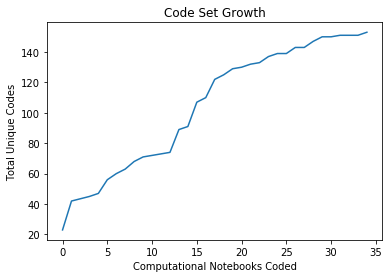

In [8]:
ax = sns.lineplot(x='coding order', y='cumulative count', markers=True, dashes=False, data=codesByArticle)
ax.set(xlabel='Computational Notebooks Coded', ylabel='Total Unique Codes', title='Code Set Growth')
plt.show()

Map codes back to the article where they were introduced to the code set.

In [9]:
for i, row in codesByArticle.iterrows():
    display(Markdown('{}. **{}**: {}'.format(i + 1, row.article, row['new codes'])))

1. **california-ccscore-analysis**: peek at data, repetitive code, calculate mean, remove incomplete data, calculate difference, format table display, filter rows, count value frequency, drop entirely duplicate rows, calculate z-score, inner join tables, adjust for season, inspect table schema, export results, change column data type, split, compute, and merge, group by single column, plot histogram, count number of records, calculate percentage difference, read as tabular data, sort table, drop columns

2. **2019-04-democratic-candidate-codonors**: calculate scaled ratio, calculate ratio, outer join tables, remove with regular expression, use public data, union tables, canonicalize column names, create a semi-unique key, sum column values, group by multiple columns, export intermediate results, change case, gather table, prevent double-counting, self join table, architect a subroutine, annotate workflow, strip whitespace, count unique values in column

3. **california-crop-production-wages-analysis**: construct table manually, architect repeating process, adjust for inflation

4. **census-hard-to-map-analysis**: slice column values, wrangle data for graphics

5. **long-term-care-db**: construct pivot table, fix data errors manually, encode table identification in row, join with lookup table, drop erroneous rows, scrape web for data, drop rows with duplicate value in one column, perform name entity resolution manually, use non-public, provided data

6. **2018-voter-registration**: pull tables out of pdf, extract single value, plot stacked bar chart, plot stacked column chart

7. **heat_and_humidity**: compute index number, generate data computationally, cartesian product

8. **2016-11-bellwether-counties**: get max value, spread table, calculate spread, create rolling window, use academic data

9. **2018-05-31-crime-and-heat-analysis**: plot scatterplot, extract property from datetime, combine seemingly disparate datasets

10. **2016-09-shy-trumpers**: use another news orgs data

11. **cube_root_law**: calculate using an external data structure

12. **2016-04-republican-donor-movements**: split column on delimiter

13. **california-h2a-visas-analysis**: plot column chart, omits data quality exploration, preserve existing values, remove all rows but the master record, geocode addresses, create a crosstab, replace na values, encoding provenance in data, trim by geographic area, trim by date range, temporary joining column, create a unique key, cache results from external service, display entire table, split and compute

14. **Endangered-Species-Act-Louisiana**: plot trendline, perform scalar multiplication

15. **Power_of_Irma**: set data confidence threshold, toggle step on and off, find worst offender, plot boxplot, look for trends, find most frequently occurring, fix incorrect calculation, tolerate dirty data, use previously cleaned data, fit a generalized linear model, select columns, value replacement, use data from colleague, plot violin plot, log-ify values, change date format

16. **wikipedia-rankings**: plot scree plot, analyze principle components, collect raw data

17. **babyname_politics**: peel and merge, concatenate columns into key, resort after merge, assign ranks, round floating point, break ties, check results of previous operation, trim by quantitative threshold, get unique values, join aggregate, natural join, data loss from aggregation

18. **2015-11-refugees-in-the-united-states**: compare total number of rows, make an incorrect conclusion, designate column as primary key

19. **employment-discrimination**: concatenate files together, combine entities by string matching, merge tables to create pivot table, align table columns for consolidation

20. **bechdel**: calculate median

21. **bob-ross**: whiten matrix, run cluster analysis

22. **nyc-trips**: full join tables

23. **work-from-home**: translate entity names manually, data too large for repo, create flag, test for equality

24. **buster-posey-mvp**: image analysis, plot line chart

25. **verge-uber-launch-dates**: 

26. **vox-central-line-infections**: filter by contains value, report rows with column number discrepancies, remove delimiting characters, sort table rows

27. **prison-admissions**: 

28. **school-star-ratings-2018**: pad column values, display rows with errors, reconcile primary keys between tables, get min value

29. **electric-car-charging-points**: define edge weights, add foreign key column, encode redundant information

30. **internal-migration-london**: 

31. **midwife-led-units**: test different computations for equality

32. **librarians**: 

33. **infrastructure-jobs**: 

34. **federal_employees_trump_2017**: resolve to arbitrary entity name among choices, create a table to lookup values

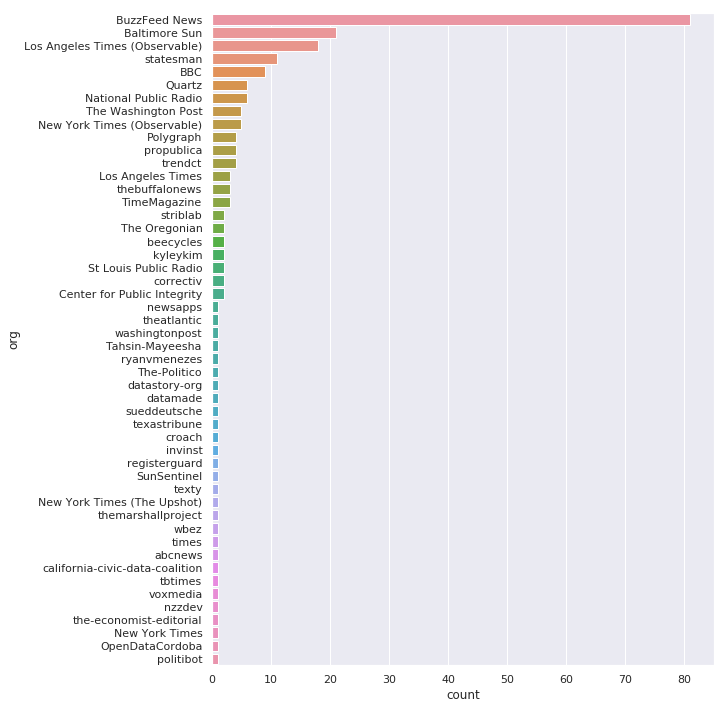

In [10]:
sns.set(rc={'figure.figsize': (9,12)})
sns.countplot(y='org', 
              data=keepers,
              order=keepers.org.value_counts().index)